In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
import numpy as np
import pylab as plt

import tabulate
from ipywidgets import Label, Button, Output, FloatSlider, HBox, VBox, Layout, HTML, Accordion
from appmode_functions import get_recompute, check_user_value, get_user_value

from widget_code_input import WidgetCodeInput

In [3]:
import scipy as sc
import numpy.linalg as npl
from numpy.linalg import norm
import scipy.linalg as scl
from scipy.spatial.distance import pdist,squareform
import ase
from tqdm import tqdm_notebook as tqdm_cs

In [4]:
from ipywidgets import interactive,FloatSlider,interact
import ipywidgets as widgets

In [5]:
from tools import manipulation_hist,manipulation_LJ_force,manipulation_Harmonique_force,manipulation_LJ,get_numerical_force,manipulation_Harmonique
from tools import visualiser_trajectoire,faire_une_chaine_circulaire,faire_une_chaine_lineaire

In [6]:
#### AVOID folding of output cell 

In [7]:
%%html

<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Developper les fonctions pour modeliser une chaine de polymere

<img src="figures/r2_r1-01.png" width="250" height="250" />

## Potentiel harmonique

Le potentiel harmonique est donné par:

$V_{har}\,\left(d\right) = k \,\left(d-r_m\right)^2,$

où $d$ est la longueur du ressort, $r_m$ est la longueur du ressort au repos et $k$ est la constante de raideur du ressort.
Si les extrémités du ressort sont données par les vecteurs $\vec{r_1} = \left(x_1,\, y_1,\,  z_1\right)$ et $\vec{r_2} = \left(x_2,\, y_2,\,  z_2\right)$ respectivement, alors $d=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2+(z_1-z_2)^2}$.


In [34]:
class SetUpHarmonicPotential(object):
    def __init__(self):        
        self.plot_box = Output()
        with self.plot_box:
            self.the_figure, self.the_plot = plt.subplots(figsize=(5,5))
            self.the_plot.set_xlabel("x [l]")
            self.the_plot.set_xlabel("Potentiel [e]")
        
        # set up the value checker
        self.check_function_output = Output()
        self.check_accordion = Accordion(children=[self.check_function_output], selected_index=None)
        self.check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')
        
        # set up the sliders
        r_m_widget = FloatSlider(
            value=2, min=0.50, max=5,step=0.2,
            description=r'\(r_m\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        k_widget = FloatSlider(
            value=2, min=0.50, max=5,step=0.2,
            description=r'\(k\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        self.sliders_dict = dict(r_m=r_m_widget,k=k_widget)
        
        # set up the test values
        self.test_values_dict = dict(d=[1,2,3,4],r_m=[1,3],k=[2,3])
        
        # set upt the code widget window
        self.code_widget = WidgetCodeInput(
            function_name="Potentiel_Harmonique", 
            function_parameters="d, r_m, k",
            docstring="""
        Implémente l'énergie potentielle associée à un ressort

        :param d: distance [l]
        :param r_m: distance de repos du ressort [l]
        :param k: force du ressort [e/l] 

        :return: Valeur de l'énergie potentielle du ressort [e]
        """,
            function_body="# Ecrit ta solution\n# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution"
        )
        
        self.widgets = [slider for slider in self.sliders_dict.values()]
        self.widgets += [self.code_widget]
        
        self.input_box = VBox([slider for slider in self.sliders_dict.values()])
        # self.plot = interactive_output(self.replot, self.sliders_dict)
    
    def display(self):
        display(self.code_widget)
        display(self.input_box, self.the_figure)
        display(self.check_accordion)
        
    def reference_func(self,d,r_m,k):
        ### Retourne la valeur du potentiel harmonique
        return k*( d - r_m)**2
    
    def replot(self, r_m, k):
        # Clean up the graph
        self.the_plot.axes.clear()

        circle1 = plt.Circle((0, 2), 0.2, color='b')
        circle2 = plt.Circle((r_m, 2), 0.2, color='r')
        self.the_plot.add_artist(circle1)
        self.the_plot.add_artist(circle2)
        r = np.linspace(-2, 6, num=100)
        self.the_plot.plot(r, self.reference_func(r,r_m,k))


        # plt.show()
        ## (Try to) plot user value
        user_value = None
        try:
            user_value = get_user_value(**{'d',r})
        except Exception:
            # Just a guard not to break the visualization, we should not end up here
            pass 
        try:
            if user_value is not None:
                self.the_plot.plot([user_value], [0], 'or')    
        except Exception:
            # We might end up here if the function does not return a float value
            pass 

        self.the_plot.set_xlim(-0.5,4)
        self.the_plot.set_ylim(-0.5,4)
        # Redraw
        self.the_figure.canvas.draw()
        self.the_figure.canvas.flush_events()


WidgetCodeInput(docstring="\n        Implémente l'énergie potentielle associée à un ressort\n\n        :param …

<IPython.core.display.Javascript object>


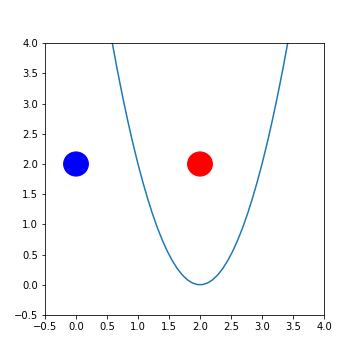

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voi…

In [35]:
setup_class = SetUpHarmonicPotential()

recompute = get_recompute(setup_class)

_ = recompute(None)

setup_class.display()

## Force d'un ressort

En 1D, la force ressentie à l'extrémité d'un ressort est:

${F}_{Har}\left(x\right) = - \frac{dV_{Har}(x)}{dx} = - 2x k \, (x - r_m).$


De la même manière, la force ressentie à l'extrémité d'un ressort en trois dimension est:

$\vec{F}_{Har}\left(\vec{r}_{12}\right)  = \frac{\vec{r}_{12} }{d} \,F_{Har}\left(d\right) =  - 2 k \, (d - r_m)  \frac{\vec{r}_{12} }{d},$

 sur la particule 2, situé en $\vec{r}_{2}=(x_2,y_2,z_2)$,

où $\vec{r}_{12}=\vec{r}_{1}-\vec{r}_{2}=(x_1-x_2,y_1-y_2,z_1-z_2)$ est le vecteur qui va d'une extrémité du ressort, situé en $\vec{r}_{1}=(x_1,y_1,z_1)$, à l'autre, situé en $\vec{r}_{2}=(x_2,y_2,z_2)$, et $d=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2+(z_1-z_2)^2}$ est la longueur du vecteur $\vec{r}_{12}$.
Donc la norme de la force harmonique est donnée par:

$F_{Har}\left(d\right) =  - 2 k \, (d - r_m)$

In [36]:
class SetUpHarmonicForce(object):
    def __init__(self):        
        self.plot_box = Output()
        with self.plot_box:
            self.the_figure, self.the_plot = plt.subplots(figsize=(5,5))
            self.the_plot.set_xlabel("x [l]")
            self.the_plot.set_xlabel("Force [e/l]")
        self.r_m, self.k_spring = 2, 1
        # set up the value checker
        self.check_function_output = Output()
        self.check_accordion = Accordion(children=[self.check_function_output], selected_index=None)
        self.check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')
        
        # set up the sliders
        d_widget = FloatSlider(
            value=self.r_m, min=0.50, max=5,step=0.1,
            description=r'\(d\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        
        self.sliders_dict = dict(d=d_widget)
        
        # set up the test values
        self.test_values_dict = dict(d=[1,2,3,4],r_m=[1,3],k=[2,3])
        
        # set upt the code widget window
        self.code_widget = WidgetCodeInput(
            function_name="Force_Harmonique", 
            function_parameters="d, r_m, k",
            docstring="""
        Calcule la norme de la force associée à un ressort

        :param d: distance entre les particules [l]
        :param r_m: distance de repos du ressort [l]
        :param k: force du ressort [e/l] 

        :return: Valeur de la norme de la force associée à un ressort [e/l]
        """,
            function_body="# Ecrit ta solution\n# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution"
        )
        
        self.widgets = [slider for slider in self.sliders_dict.values()]
        self.widgets += [self.code_widget]
        
        self.input_box = VBox([slider for slider in self.sliders_dict.values()])
    
    def display(self):
        display(self.code_widget)
        display(self.input_box, self.the_figure)
        display(self.check_accordion)
        
    def reference_func(self,d,r_m,k):
        ### Retourne la valeur de la force harmonique
        return - 2*k * (d - r_m)
    def harm_pot(self,d,r_m,k):
        ### Retourne la valeur du potentiel harmonique
        return k*( d - r_m)**2
    
    def replot(self, d):
        font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
        
        r_m, k_spring = self.r_m, self.k_spring
        
        # Clean up the graph
        self.the_plot.axes.clear()

        circle1 = plt.Circle((0, 2), 0.2, color='b')
        circle2 = plt.Circle((d, 2), 0.2, color='r')
        self.the_plot.add_artist(circle1)
        self.the_plot.add_artist(circle2)
        
        st = np.array([d,2])
        if abs(d -r_m) > 1e-12:
            end = np.array([self.reference_func(d,r_m,k_spring),2])
            nnn = end - np.array([0,2])
            self.the_plot.arrow(st[0], st[1],nnn[0]/abs(self.reference_func(0.5,r_m,k_spring)), 
                     nnn[1], head_width=0.25, head_length=0.15, fc='k', ec='k',width=0.05)
            plt.text(2, 3, r'$F_{Harm}=$'+'{val:.1f}'.format(val=end[0]), fontdict=font)
        else:
            plt.text(2, 3, r'$F_{Harm}=$'+'{val:.1f}'.format(val=0), fontdict=font)
            
        r = np.linspace(-0.5, 4, num=100)
        self.the_plot.plot(r, self.harm_pot(r,r_m,k_spring))
        
        
        ## (Try to) plot user value
        user_value = None
        try:
            user_value = get_user_value(**{'d',r})
        except Exception:
            # Just a guard not to break the visualization, we should not end up here
            pass 
        try:
            if user_value is not None:
                self.the_plot.plot([user_value], [0], 'or')    
        except Exception:
            # We might end up here if the function does not return a float value
            pass 

        self.the_plot.set_xlim(-0.5,4)
        self.the_plot.set_ylim(-0.5,4)
        # Redraw
        self.the_figure.canvas.draw()
        self.the_figure.canvas.flush_events()
        

WidgetCodeInput(docstring='\n        Calcule la norme de la force associée à un ressort\n\n        :param d: d…

<IPython.core.display.Javascript object>


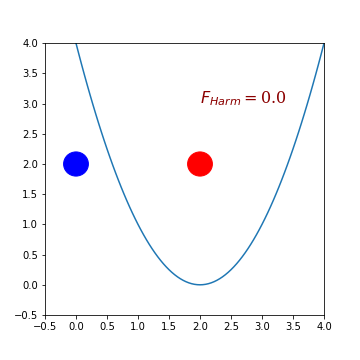

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voi…

In [24]:
setup_class = SetUpHarmonicForce()

recompute = get_recompute(setup_class)

_ = recompute(None)

setup_class.display()

## Potentiel de Lennard Jones

Le potentiel de Lennard Jones exercé par la particule 1 sur la particule 2 est:

$V_{LJ}\left(d\right)= \epsilon \left[\left(\frac{r_m}{d}\right)^{12}-2\left(\frac{r_m}{d}\right)^{6}\right],$

où $\vec{r}_{12}=\vec{r}_{1}-\vec{r}_{2}=(x_1-x_2,y_1-y_2,z_1-z_2)$ est le vecteur qui va de la particule 1, situé en $\vec{r}_{1}=(x_1,y_1,z_1)$, sur la particule 2, situé en $\vec{r}_{2}=(x_2,y_2,z_2)$, et $d=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2+(z_1-z_2)^2}$ est la longueur du vecteur $\vec{r}_{12}$.


In [37]:
class SetUpLJPotential(object):
    def __init__(self):        
        self.plot_box = Output()
        with self.plot_box:
            self.the_figure, self.the_plot = plt.subplots(figsize=(5,5))
            self.the_plot.set_xlabel("x [l]")
            self.the_plot.set_xlabel("Potentiel [e]")
        
        # set up the value checker
        self.check_function_output = Output()
        self.check_accordion = Accordion(children=[self.check_function_output], selected_index=None)
        self.check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')
        
        # set up the sliders
        r_m_widget = FloatSlider(
            value=2, min=0.10, max=5,step=0.2,
            description=r'\(r_m\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        epsilon_widget = FloatSlider(
            value=2, min=0.10, max=5,step=0.2,
            description=r'\(k\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        self.sliders_dict = dict(r_m=r_m_widget,epsilon=epsilon_widget)
        
        # set up the test values
        self.test_values_dict = dict(d=[1,2,3,4],r_m=[1,3],epsilon=[2,3])
        
        # set upt the code widget window
        self.code_widget = WidgetCodeInput(
            function_name="Potentiel_Lennard_Jones", 
            function_parameters="d, r_m, epsilon",
            docstring="""
        Implémente l'énergie potentielle associée à un ressort

        :param d: distance [l]
        :param r_m: distance au minimum [l]
        :param epsilon: échelle d'énergie [e] 

        :return: Valeur de l'énergie potentielle de Lennard-Jones [e]
        """,
            function_body="# Ecrit ta solution\n# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution"
        )
        
        self.widgets = [slider for slider in self.sliders_dict.values()]
        self.widgets += [self.code_widget]
        
        self.input_box = VBox([slider for slider in self.sliders_dict.values()])
    
    def display(self):
        display(self.code_widget)
        display(self.input_box, self.the_figure)
        display(self.check_accordion)
        
    def reference_func(self,d,r_m,epsilon):
        ### Retourne la valeur du potentiel LJ
        return epsilon*( (r_m/d)**12 - 2*(r_m/d)**6)
    
    def replot(self, r_m, epsilon):
        # Clean up the graph
        self.the_plot.axes.clear()

        circle1 = plt.Circle((0, 2), 0.2, color='b')
        circle2 = plt.Circle((r_m, 2), 0.2, color='r')
        self.the_plot.add_artist(circle1)
        self.the_plot.add_artist(circle2)
        r = np.linspace(-2, 6, num=200)
        self.the_plot.plot(r, self.reference_func(r,r_m,epsilon))
        
        # plt.show()
        ## (Try to) plot user value
        user_value = None
        try:
            user_value = get_user_value(**{'d',r})
        except Exception:
            # Just a guard not to break the visualization, we should not end up here
            pass 
        try:
            if user_value is not None:
                self.the_plot.plot([user_value], [0], 'or')    
        except Exception:
            # We might end up here if the function does not return a float value
            pass 

        self.the_plot.set_xlim(-0.5,4)
        self.the_plot.set_ylim(-2.5,3)
        # Redraw
        self.the_figure.canvas.draw()
        self.the_figure.canvas.flush_events()


WidgetCodeInput(docstring="\n        Implémente l'énergie potentielle associée à un ressort\n\n        :param …

<IPython.core.display.Javascript object>


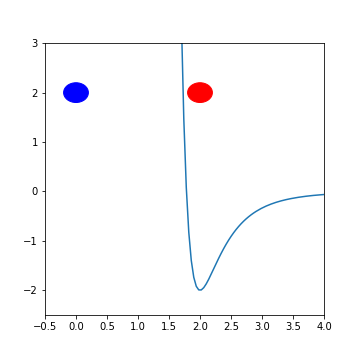

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voi…

In [38]:


setup_class = SetUpLJPotential()

recompute = get_recompute(setup_class)

_ = recompute(None)

setup_class.display()

## Force de Lennard Jones

La force de Lennard Jones exercée par une particule 1 sur une particule 2 en trois dimension est:

$\vec{F}_{LJ}\left(\vec{r}_{12}\right)  = \frac{\vec{r}_{12} }{d} \,F_{LJ}\left(d\right) = \frac{\vec{r}_{12} }{d}  \frac{12 \epsilon}{d} \left[\left(\frac{r_m}{d}\right)^{12}-\left(\frac{r_m}{d}\right)^{6}  \right],$

où $\vec{r}_{12}=\vec{r}_{1}-\vec{r}_{2}=(x_1-x_2,y_1-y_2,z_1-z_2)$ est le vecteur qui va de la particule 1, situé en $\vec{r}_{1}=(x_1,y_1,z_1)$, sur la particule 2, situé en $\vec{r}_{2}=(x_2,y_2,z_2)$, et $d=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2+(z_1-z_2)^2}$ est la longueur du vecteur $\vec{r}_{12}$.
Donc la norme de la force de Lennard Jones est donnée par:

$F_{LJ}\left(d\right) = \frac{\vec{r}_{12} }{d}  \frac{12 \epsilon}{d} \left[\left(\frac{r_m}{d}\right)^{12}-\left(\frac{r_m}{d}\right)^{6}  \right]$

In [39]:
class SetUpLJForce(object):
    def __init__(self):        
        self.plot_box = Output()
        with self.plot_box:
            self.the_figure, self.the_plot = plt.subplots(figsize=(5,5))
            self.the_plot.set_xlabel("x [l]")
            self.the_plot.set_xlabel("Force [e/l]")
        self.r_m, self.epsilon = 2, 1
        # set up the value checker
        self.check_function_output = Output()
        self.check_accordion = Accordion(children=[self.check_function_output], selected_index=None)
        self.check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')
        
        # set up the sliders min=r_m-0.3, max=4, step=0.1
        d_widget = FloatSlider(
            value=self.r_m, min=self.r_m-0.3, max=4,step=0.1,
            description=r'\(d\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        
        self.sliders_dict = dict(d=d_widget)
        
        # set up the test values
        self.test_values_dict = dict(d=[1,2,3,4],r_m=[1,3],epsilon=[2,3])
        
        # set upt the code widget window
        self.code_widget = WidgetCodeInput(
            function_name="Force_Lennard_Jones", 
            function_parameters="d, r_m, epsilon",
            docstring="""
        Calcule la norme de la force associée à un ressort

        :param d: distance entre les particules [l]
        :param r_m: distance du minimum [l]
        :param epsilon: force de Lennard Jones [e] 

        :return: Valeur de la norme de la force associée au potentiel de Lennard Jones [e/l]
        """,
            function_body="# Ecrit ta solution\n# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution"
        )
        
        self.widgets = [slider for slider in self.sliders_dict.values()]
        self.widgets += [self.code_widget]
        
        self.input_box = VBox([slider for slider in self.sliders_dict.values()])
    
    def display(self):
        display(self.code_widget)
        display(self.input_box, self.the_figure)
        display(self.check_accordion)
        
    def reference_func(self,d,r_m,epsilon):
        ### Retourne la valeur de la force harmonique
        return  12  * epsilon * ( (r_m/d)**12 - (r_m/d)**6 ) / d
    
    def LJ_pot(self,d,r_m,epsilon):
        ### Retourne la valeur du potentiel LJ
        return epsilon*( (r_m/d)**12 - 2*(r_m/d)**6)
    
    def replot(self, d):
        font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
        
        r_m, epsilon = self.r_m, self.epsilon
        
        # Clean up the graph
        self.the_plot.axes.clear()

        circle1 = plt.Circle((0, 2), 0.2, color='b')
        circle2 = plt.Circle((d, 2), 0.2, color='r')
        self.the_plot.add_artist(circle1)
        self.the_plot.add_artist(circle2)
        
        st = np.array([d,2])
        if abs(d - r_m) > 1e-12:
            end = np.array([self.reference_func(d,r_m,epsilon),2])
            nnn = end - np.array([0,2])
            self.the_plot.arrow(st[0], st[1],nnn[0]/abs(self.reference_func(r_m-0.3,r_m,epsilon)), 
                     nnn[1], head_width=0.25, head_length=0.15, fc='k', ec='k',width=0.05)
            plt.text(2, 0.65, r'$F_{LJ}=$'+'{val:.1f}'.format(val=end[0]), fontdict=font)
        else:
            plt.text(2, 0.65, r'$F_{LJ}=$'+'{val:.1f}'.format(val=0), fontdict=font)
            
        r = np.linspace(0.01, 4, num=1000)
        self.the_plot.plot(r, self.LJ_pot(r,r_m,epsilon))
        
        
        ## (Try to) plot user value
        user_value = None
        try:
            user_value = get_user_value(**{'d',r})
        except Exception:
            # Just a guard not to break the visualization, we should not end up here
            pass 
        try:
            if user_value is not None:
                self.the_plot.plot([user_value], [0], 'or')    
        except Exception:
            # We might end up here if the function does not return a float value
            pass 

        self.the_plot.set_xlim(-0.5,4)
        self.the_plot.set_ylim(-1.5,3)
        # Redraw
        self.the_figure.canvas.draw()
        self.the_figure.canvas.flush_events()
        

WidgetCodeInput(docstring='\n        Calcule la norme de la force associée à un ressort\n\n        :param d: d…

<IPython.core.display.Javascript object>


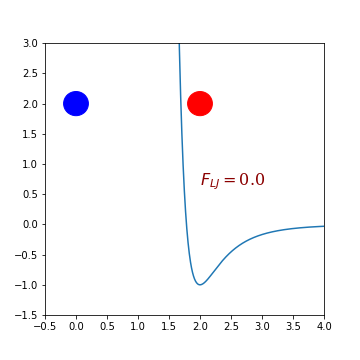

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voi…

In [40]:
setup_class = SetUpLJForce()

recompute = get_recompute(setup_class)

_ = recompute(None)

setup_class.display()

# Calculer les forces entre les particules

Le polymère est représenté par une chaine de $N$ particules. 
+ La chaine est modélisée par l'interaction harmonique entre les particules en suivant leur numérotation: la particule $i$ interagit avec la particule $i+1$ et $i-1$ et les deux extrémités sont libre. 
+ L'interaction entre toutes les particules est approximée par la force de Lennard Jones. La force appliquée sur la particule $i$ est donc:

$\vec{F}_{i} = \sum_{j}^{N} \left(\vec{F}_{LJ}^{\,ij} + \vec{F}_{Harm}^{\,ij} \right),$

$\vec{F}_{i} =  \sum_{j,j\neq i}^{N} \frac{\vec{r}^{\,ij}}{d^{\,ij}} \,F_{LJ}\left(d^{\,ij}\right)  + \left[ \frac{\vec{r}^{\,i-1,i}}{d^{\,i-1,i}} \,F_{Harm}\left(d^{\,i-1,i}\right) + \frac{\vec{r}^{\,i,i+1}}{d^{\,i,i+1}} \,F_{Harm}\left(d^{\,i,i+1}\right) \right],$

où le vecteur $\vec{r}^{\,ij} = \left(x^{i}-x^{j},\,y^{i}-y^{j},\,  z^{i}-z^{j}\right)  $ est le vecteur qui va de la particule $i$ à la particule $j$ et $d^{\,ij}=\sqrt{(x_i-x_j)^2+(y_i-y_j)^2+(z_i-z_j)^2}$ est la longueur du vecteur $\vec{r}^{\,ij}$.


## Calculer les forces de Lennard Jones entre chaque particules


$\vec{F}_{i}^{LJ} =  \sum_{j,j\neq i}^{N} \frac{\vec{r}^{\,ij}}{d^{\,ij}} \,F_{LJ}\left(d^{\,ij}\right)$


<img src="figures/poly_chain-01.png" width="500" height="250" />

**Algorithme**:

$E_{LJ} = 0$ et $\vec{F}_{i}^{LJ}=0$ pour i=0,1,...,Nparticule-1

pour i de 0 a Nparticule-1:

    pour j de 0 a Nparticule-1:
    
        si j est different de i:
            
            Ajouter à la force et à l'energie la contribution de ij
+ $\vec{F}_{i}^{LJ} \mathrel{+}= \frac{\vec{r}^{\,ij}}{d^{\,ij}} \,F_{LJ}\left(d^{\,ij}\right)$
+ $E_{LJ} \mathrel{+}= 0.5 V_{LJ}\left(d^{\,ij}\right)$
        

In [41]:
class SetUpLJForces(object):
    def __init__(self):        
        
        # set up the value checker
        self.check_function_output = Output()
        self.check_accordion = Accordion(children=[self.check_function_output], selected_index=None)
        self.check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')
        
        self.check_button = widgets.Button(description="Valide ta solution")
        
        self.sliders_dict = dict()
        
        
        # set up the test values
        np.random.seed(10)
        positions_list = [np.random.rand(5,3), np.random.rand(5,3), np.random.rand(5,3)]
        self.test_values_dict = dict(positions=positions_list,r_m=[1,3],epsilon=[2,3])
        
        # set upt the code widget window
        self.code_widget = WidgetCodeInput(
            function_name="Force_Lennard_Jones_entre_particules", 
            function_parameters="positions, r_m, epsilon",
            docstring="""
        Calcule les forces de Lennard Jones entre les particules du système

        :param positions: list des positions des particules de la forme (Nparticules, 3) [l]
        :param r_m: distance du minimum [l]
        :param epsilon: force de Lennard Jones [e] 

        :return: list des forces de Lennard Jones de la forme (Nparticules, 3) [e/l]
        """,
            function_body=
"""import numpy as np
from Exercise_functions import Force_LennardJones
# Nombre de particules dans le système
Nparticule,_ = positions.shape
# liste des forces appliquees a chaque particule
forces = np.zeros((Nparticule,3))
energy = 0

# Ecrit ta solution
# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution
### Calcule la somme des forces de LJ appliquées par toutes les particules j sur chaque particule i


return forces
               """
        )
        
        self.widgets = [slider for slider in self.sliders_dict.values()]
        self.widgets += [self.code_widget] + [self.check_button]
        
        self.input_box = VBox([slider for slider in self.sliders_dict.values()])
    
    def display(self):
        display(self.code_widget)
        display(self.check_button)
        display(self.check_accordion)
        
    def Force_LennardJones(self,d,r_m,epsilon):
        ### Retourne la valeur de la force harmonique
        return  12  * epsilon * ( (r_m/d)**12 - (r_m/d)**6 ) / d
    
    def Potentiel_LennardJones(self,d,r_m,epsilon):
        ### Retourne la valeur du potentiel LJ
        return epsilon*( (r_m/d)**12 - 2*(r_m/d)**6)
        
    def reference_func(self,positions,r_m,epsilon):
        import numpy as np
        # Nombre de particules dans le système
        Nparticule,_ = positions.shape
        # liste des forces appliquees a chaque particule
        forces = np.zeros((Nparticule,3))

        ### Calcule la somme des forces de LJ appliquées par toutes les particules j sur chaque particule i
        for ipart in range(Nparticule):
            for jpart in range(Nparticule):
                if jpart != ipart:
                    r = positions[ipart]-positions[jpart]
                    d = np.linalg.norm(r)
                    forces[ipart] += (r/d)*self.Force_LennardJones(d,r_m,epsilon)
                    
        return forces
    
    
    def replot(self, *args, **kwargs):
        pass
        

In [42]:
setup_class = SetUpLJForces()

recompute = get_recompute(setup_class)

_ = recompute(None)

setup_class.display()

WidgetCodeInput(docstring='\n        Calcule les forces de Lennard Jones entre les particules du système\n\n  …

Button(description='Valide ta solution', style=ButtonStyle())

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voi…

## Calculer les forces des ressorts entre chaque particules de la chaine

$\vec{F}_{i}^{Harm} =  \frac{\vec{r}^{\,i-1,i}}{d^{\,i-1,i}}\,F_{Harm}\left(d^{\,i-1,i}\right) + \frac{\vec{r}^{\,i,i+1}}{d^{\,i,i+1}} \,F_{Harm}\left(d^{\,i,i+1}\right) $

<img src="figures/spring_chain.png" width="500" height="250" />


**Algorithme**:


$E_{Harm} = 0$ et $\vec{F}_{i}^{Harm} = 0 $ pour i=0,1,...,Nparticule-1

pour i de 0 a Nresort:
+ $\vec{F}_{i}^{Harm} =  \vec{\hat{r}}^{\,i,i+1} \,F_{Harm}\left(d^{\,i,i+1}\right)$
+ $\vec{F}_{i+1}^{Harm} =  - \vec{\hat{r}}^{\,i,i+1} \,F_{Harm}\left(d^{\,i,i+1}\right)$
+ $E_{Harm} \mathrel{+}= V_{Harm}\left(d^{\,i,i+1}\right)$

In [12]:
class SetUpHarmoniqueForces(object):
    def __init__(self):        
        
        # set up the value checker
        self.check_function_output = Output()
        self.check_accordion = Accordion(children=[self.check_function_output], selected_index=None)
        self.check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')
        
        self.check_button = widgets.Button(description="Valide ta solution")
        
        self.sliders_dict = dict()
                
        # set up the test values
        np.random.seed(10)
        positions_list = [np.random.rand(5,3), np.random.rand(5,3), np.random.rand(5,3)]
        self.test_values_dict = dict(positions=positions_list,r_m=[1,3],k=[2,3])
        
        # set upt the code widget window
        self.code_widget = WidgetCodeInput(
            function_name="Force_Harmonique_entre_particules", 
            function_parameters="positions, r_m, k",
            docstring="""
        Calcule les forces de la chaine de ressorts entre les particules du système

        :param positions: list des positions des particules de la forme (Nparticules, 3) [l]
        :param r_m: distance du minimum [l]
        :param k: force du ressort [e/l] 

        :return: list des forces de ressort de la forme (Nparticules, 3) [e/l]
        """,
            function_body=
"""import numpy as np
from Exercise_functions import Force_Harmonique
Nparticule,_ = positions.shape
Nresort = Nparticule-1
# liste des forces appliquees a chaque particule
forces = np.zeros((Nparticule,3))

# Ecrit ta solution
# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution
### Calcule la somme des forces de harmoniques entre particules consécutives


return forces
               """
        )
        
        self.widgets = [slider for slider in self.sliders_dict.values()]
        self.widgets += [self.code_widget] + [self.check_button]
        
        self.input_box = VBox([slider for slider in self.sliders_dict.values()])
    
    def display(self):
        display(self.code_widget)
        display(self.check_button)
        display(self.check_accordion)
        
    def Force_Harmonique(self,d,r_m,k):
        ### Retourne la norme de la force harmonique
        return  - 2*k * (d - r_m)
    
    def Potentiel_Harmonique(self,d,r_m,k):
        ### Retourne la valeur du potentiel harmonique
        return k*( d - r_m)**2
        
    def reference_func(self,positions,r_m,k):
        Nparticule,_ = positions.shape
        Nresort = Nparticule-1
        # liste des forces appliquees a chaque particule
        forces = np.zeros((Nparticule,3))
        for iresort in range(Nresort):
            r = positions[iresort]-positions[iresort+1]
            d = np.linalg.norm(r)
            f =  self.Force_Harmonique(d,r_m,k) * (r/d)
            forces[iresort] += f
            forces[iresort+1] -= f

        return forces
    
    
    def replot(self, *args, **kwargs):
        pass
        

In [13]:
setup_class = SetUpHarmoniqueForces()

recompute = get_recompute(setup_class)

_ = recompute(None)

setup_class.display()

WidgetCodeInput(docstring='\n        Calcule les forces de la chaine de ressorts entre les particules du systè…

Button(description='Valide ta solution', style=ButtonStyle())

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voi…

## Thermostat de Andersen

Pour modeliser l'effet du monde exterieur sur la chaine de polymère, les composantes des vitesses sont aleatoirement remplacées par des valeurs tirées d'une distribution gaussienne centrée en zéro. Cela peux correspondre a l'effet de collisions successives et aleatoires entre les particules simulee et d'autres 'particules' de l'environement qui ne sont pas explicitement inclues dans la simulation

<IPython.core.display.Javascript object>


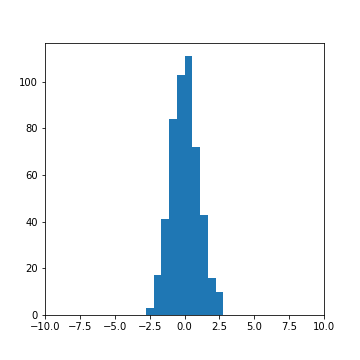

interactive(children=(FloatSlider(value=1.0, description='\\(T\\)', max=7.0, min=0.1, step=0.3), Output()), _d…

In [20]:
### Change la temperature et observe comment les valeurs possible des nouvelles vitesses changent
manipulation_hist()

In [84]:
def andersen_thermostat(velocities,temperature,freq,dt):
    if temperature > 0:
        vshape = velocities.shape
        mask = np.random.rand(velocities.size) < 1 - np.exp(-freq*dt)
        Nupdate = np.sum(mask)
        velocities = velocities.flatten()
        velocities[mask] = np.sqrt(temperature)*np.random.normal(loc=0.0, scale=1,size=(Nupdate,))
        velocities = velocities.reshape(vshape)
    return velocities

## Simulateur

Faire evoluer le systeme de N particules de sont etat initial $\left(\vec{r}(t_{init}),\vec{v}(t_{init},\vec{a}(t_{init})\right)$ un etat final $\left(\vec{r}(t_{final}),\vec{v}(t_{final}),\vec{a}(t_{final})\right)$ en passant par $N_{etape}$ intermédiaire.

**Procédure**:
+ Initialiser les positions, les vitesses et les accelerations
+ Integrer $N_{étape}$ fois les equations du mouvement avec l'integrateur de Verlet en enregistrant les positions et vitesses a chaque étape

**Intégration de Verlet**

A un instant $t$, on connait les postions, vitesses et accelerations des particules $\vec{x}_{t}$, $\vec{v}_{t}$, $\vec{a}_{t}$ et on veut faire avancer le system d'un interval $\Delta t$ dans le temps en calculant $\vec{x}_{t+\Delta t}$, $\vec{v}_{t+\Delta t}$, $\vec{a}_{t+\Delta t}$.

**Algorithme**:

+ applique le thermostat 

+ $\vec{v}_{t+\Delta t/2}= \vec{v}_{t} + 0.5\,\Delta t\,\vec{a}_{t}$

+ $\vec{x}_{t+\Delta t} = \vec{x}_{t}+\Delta t\,\vec{v}_{t+\Delta t/2}$

+ $\vec{a}_{t+\Delta t} = \frac{\vec{F}_{t+\Delta t}}{m} = \left[\vec{F}_{LJ}\left(\vec{x}_{t+\Delta t}\right)+\vec{F}_{Har}\left(\vec{x}_{t+\Delta t}\right)\right]\,/\,m$ 

+ $\vec{v}_{t+\Delta t} = \vec{v}_{t+\Delta t/2}+0.5\,\Delta t\, \vec{a}_{t+\Delta t} $

\begin{equation}
\begin{split}
\vec{v}_{t+\Delta t/2}=& \vec{v}_{t} + 0.5\,\Delta t\,\vec{a}_{t} \\
\vec{x}_{t+\Delta t} = &\vec{x}_{t}+\Delta t\,\vec{v}_{t+\Delta t/2}\\
\vec{a}_{t+\Delta t} =& \frac{\vec{F}_{t+\Delta t}}{m} \\
\vec{v}_{t+\Delta t} =& \vec{v}_{t+\Delta t/2}+0.5\,\Delta t\, \vec{a}_{t+\Delta t} \\
\end{split}
\end{equation}

In [20]:
class SetUpVerlet(object):
    def __init__(self):        
        # set up the value checker
        self.check_function_output = Output()
        self.check_accordion = Accordion(children=[self.check_function_output], selected_index=None)
        self.check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')
        
        self.check_button = widgets.Button(description="Valide ta solution")
        
        self.sliders_dict = dict()
        
        Nstep = 100
        dt = 0.001
        np.random.seed(10)
        vitesses = np.random.rand(5,3)
        positions = np.random.rand(5,3)*2
        r_m, epsilon, k_spring = 1, 3, 2
        temperature, masse = 4, 1
        
        self.test_values_dict = dict(Nstep=[Nstep],dt=[dt],positions=[positions],vitesses=[vitesses],r_m=[r_m],epsilon=[epsilon],k=[k_spring],temperature=[temperature],masse=[masse])
        
        # set upt the code widget window
        self.code_widget = WidgetCodeInput(
            function_name="Velocity_Verlet_Algorithm", 
            function_parameters="positions, vitesses, masse, temperature, r_m, epsilon, k, Nstep, dt",
            docstring="""
        Intègre les equations du mouvement avec l'integrateur de Verlet

        :param positions: list des positions des particules de la forme (Nparticules, 3) [l]
        :param vitesses: list des positions des particules de la forme (Nparticules, 3) [l/t]
        :param masse: masse des particules [m] 
        :param temperature: Temperature du système [e/k_B] 
        :param r_m: distance d'équilibre entre les particules [l] 
        :param epsilon: energie d'interaction de Lennard Jones [e] 
        :param k: force du ressort [e/l] 
        :param Nstep: Nombre de pas de temps à faire
        :param dt: pas de temps de l'integrateur [t] 

        :return: list des positions [l] de la forme (Nparticules, 3) 
        """,
            function_body=
"""import numpy as np
from Exercise_functions import calcule_forces, andersen_thermostat
Nparticule,_ = positions.shape
# liste des forces appliquees a chaque particule
forces = np.zeros_like(positions)
# list des accelerations de chaque particules
accelerations = np.zeros_like(positions)

frequence_du_thermostat = np.sqrt(2)*np.sqrt(2*k)
# Ecrit ta solution

return positions
               """
        )
        
        self.widgets = [slider for slider in self.sliders_dict.values()]
        self.widgets += [self.code_widget] + [self.check_button]
        
        self.input_box = VBox([slider for slider in self.sliders_dict.values()])
    
    def display(self):
        display(self.code_widget)
        display(self.check_button)
        display(self.check_accordion)
        
    def Force_Harmonique(self,d,r_m,k):
        ### Retourne la norme de la force harmonique
        return  - 2*k * (d - r_m)
    def Force_LennardJones(self,d,r_m,epsilon):
        ### Retourne la valeur de la force harmonique
        return  12  * epsilon * ( (r_m/d)**12 - (r_m/d)**6 ) / d
    def get_forces_harm(self,positions,r_m,k):
        Nparticule,_ = positions.shape
        Nresort = Nparticule-1
        # liste des forces appliquees a chaque particule
        forces = np.zeros((Nparticule,3))
        for iresort in range(Nresort):
            r = positions[iresort]-positions[iresort+1]
            d = np.linalg.norm(r)
            f =  self.Force_Harmonique(d,r_m,k_spring) * (r/d)
            forces[iresort] += f
            forces[iresort+1] -= f

        return forces
    
    def get_forces_lj(self,positions,r_m,epsilon):
        import numpy as np
        # Nombre de particules dans le système
        Nparticule,_ = positions.shape
        # liste des forces appliquees a chaque particule
        forces = np.zeros((Nparticule,3))

        ### Calcule la somme des forces de LJ appliquées par toutes les particules j sur chaque particule i
        for ipart in range(Nparticule):
            for jpart in range(Nparticule):
                if jpart != ipart:
                    r = positions[ipart]-positions[jpart]
                    d = np.linalg.norm(r)
                    forces[ipart] += (r/d)*self.Force_LennardJones(d,r_m,epsilon)
                    
        return forces
    def calculer_les_forces(self,positions,r_m,epsilon,k_spring):
        F_harm = self.get_forces_harm(positions,r_m,k_spring)
        F_LJ = self.get_forces_lj(positions,r_m,epsilon)
        return F_harm+F_LJ
    
    def reference_func(self,Nstep,dt,positions,vitesses,r_m,epsilon,k,temperature,masse):
        from Exercise_functions import calcule_forces, andersen_thermostat
        accelerations = np.zeros_like(positions)
        
        frequence_du_thermostat = np.sqrt(2)*np.sqrt(2*k)
        ### Faire avancer d'un pas le system: implementer l'algorithme de l'integrateur de Verlet
        
        forces = calcule_forces(positions,r_m,epsilon,k)
        for it in range(Nstep):
            # applique le thermostat a tous les thermostat_Nstep
            vitesses = andersen_thermostat(vitesses,temperature,frequence_du_thermostat,dt)
            # avance d'un demi pas pour les vitesses
            vitesses = vitesses + 0.5 * dt * accelerations
            # avance d'un pas complet pour les positions
            positions = positions + dt * vitesses
            # Calcule les forces
            forces = calcule_forces(positions,r_m,epsilon,k)
            # F = ma
            accelerations = forces / masse
            # avance d'un demi pas les vitesses
            vitesses = vitesses + 0.5 * dt * accelerations
        
        return positions
    
    def replot(self, *args, **kwargs):
        pass
        

In [21]:
setup_class = SetUpVerlet()

recompute = get_recompute(setup_class)

_ = recompute(None)

setup_class.display()

WidgetCodeInput(docstring="\n        Intègre les equations du mouvement avec l'integrateur de Verlet\n\n      …

Button(description='Valide ta solution', style=ButtonStyle())

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voi…

## Construire une system initial et le visualiser

In [157]:
view = visualiser_trajectoire([faire_une_chaine_circulaire(N=10,r_m=1.5)],1)
view

NGLWidget()

In [158]:
view = visualiser_trajectoire([faire_une_chaine_lineaire(N=10,r_m=1)],1)
view

NGLWidget()